# Huilin Chang (hc5hq), Gavin Wiehl (gtw4vx), Travis Vitello (tjv9qh)

## 8/2/2020

DS5559

NOTE: This notebook only considers the Amazon "Movies and TV" data available here: http://jmcauley.ucsd.edu/data/amazon/

This notebook uses PySpark to process reviews, tokenize them, and the applies the wordcloud method in Python.

In [1]:
!pip install --user wordcloud # Needed to bring Word CLoud method into Rivanna

## Import Methods

In [2]:
import json

In [4]:
import os
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [5]:
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel

# Load and parse the data
# Read data in json format
df = spark.read.json("reviews_Movies_and_TV_5.json.gz")


In [6]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

## Typical Data

In [7]:
df.show(5)

+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|0005019281| [0, 0]|    4.0|This is a charmin...|02 26, 2008| ADZPIG9QOCDG5|Alice L. Larson "...|good version of a...|    1203984000|
|0005019281| [0, 0]|    3.0|It was good but n...|12 30, 2013|A35947ZP82G7JH|       Amarah Strack|Good but not as m...|    1388361600|
|0005019281| [0, 0]|    3.0|Don't get me wron...|12 30, 2013|A3UORV8A9D5L2E|     Amazon Customer|Winkler's Perform...|    1388361600|
|0005019281| [0, 0]|    5.0|Henry Winkler is ...|02 13, 2008|A1VKW06X1O2X7V|Amazon Customer "...|It's an enjoyable...|    1202860800|
|0005019281| [0, 0]|    4.0|This is one of th...|12 22, 2013|A

In [8]:
import json
import pandas as pd
data_df = pd.read_json('reviews_Baby_5.json.gz', lines=True)

## Explore Data

In [9]:
data_df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1HK2FQW6KXQB2,097293751X,"Amanda Johnsen ""Amanda E. Johnsen""","[0, 0]",Perfect for new parents. We were able to keep ...,5,Awesine,1373932800,"07 16, 2013"
1,A19K65VY14D13R,097293751X,angela,"[0, 0]",This book is such a life saver. It has been s...,5,Should be required for all new parents!,1372464000,"06 29, 2013"
2,A2LL1TGG90977E,097293751X,Carter,"[0, 0]",Helps me know exactly how my babies day has go...,5,Grandmother watching baby,1395187200,"03 19, 2014"
3,A5G19RYX8599E,097293751X,cfpurplerose,"[0, 0]",I bought this a few times for my older son and...,5,repeat buyer,1376697600,"08 17, 2013"
4,A2496A4EWMLQ7,097293751X,C. Jeter,"[0, 0]",I wanted an alternative to printing out daily ...,4,Great,1396310400,"04 1, 2014"
...,...,...,...,...,...,...,...,...,...
160787,A30J0DKNKCF7SR,B00L13XFIE,SD,"[0, 0]",Bought this as a baby gift and my friend heard...,5,Great baby gift,1391126400,"01 31, 2014"
160788,AG4E44KM93P4L,B00L13XFIE,Silofish,"[0, 1]",I am new to cloth diapering. I was leery that ...,4,Not too bulky,1343606400,"07 30, 2012"
160789,A2UZUH4QHV4HA1,B00L13XFIE,"S. Smith ""sunnshyne309""","[0, 0]",My friend is planning on cloth diapering and I...,5,great help!,1364256000,"03 26, 2013"
160790,A2Z26PUQPMT5JV,B00L13XFIE,Stephanie S. Kim,"[0, 0]",We LOVE the organic cotton/hemp inserts. They'...,5,Love these diapers!,1391731200,"02 7, 2014"


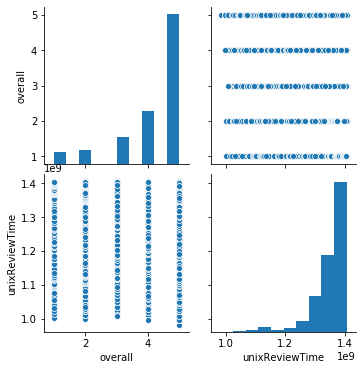

In [10]:
import seaborn as sns
sns.pairplot(data_df)

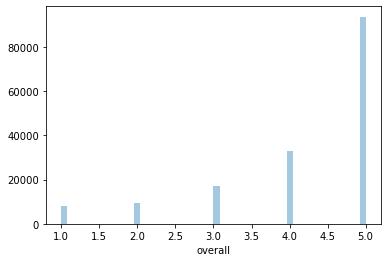

In [11]:
from matplotlib import pyplot as plt
sns.distplot(data_df['overall'],kde = False)
plt.show()

In [12]:
data_df.count()

reviewerID        160792
asin              160792
reviewerName      159427
helpful           160792
reviewText        160792
overall           160792
summary           160792
unixReviewTime    160792
reviewTime        160792
dtype: int64

In [13]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

In [14]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [15]:
df_n = df.select("reviewText")

In [16]:
df.describe("overall").show()

+-------+-----------------+
|summary|          overall|
+-------+-----------------+
|  count|          1697533|
|   mean|4.110648217148062|
| stddev|1.197614752395534|
|    min|              1.0|
|    max|              5.0|
+-------+-----------------+



## Remove netutal: overall = 3

In [17]:
df1 = df.filter("overall != 3")

In [18]:
from pyspark.ml.feature import Bucketizer
splits = [-float("inf"), 4, float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="overall", outputCol="label")

In [19]:
df2= bucketizer.transform(df1)

In [20]:
df2.groupBy("overall","label").count().show()

+-------+-----+------+
|overall|label| count|
+-------+-----+------+
|    2.0|  0.0|102410|
|    5.0|  1.0|906608|
|    1.0|  0.0|104219|
|    4.0|  1.0|382994|
+-------+-----+------+



In [21]:
df3 = df2.groupBy("reviewText","label").count().show()

+--------------------+-----+-----+
|          reviewText|label|count|
+--------------------+-----+-----+
|This is one of my...|  1.0|    1|
|Great great great...|  1.0|    1|
|The story: pricel...|  1.0|    1|
|Good depiction an...|  1.0|    1|
|This is a fantast...|  1.0|    1|
|A beautiful trans...|  1.0|    1|
|i have to say tha...|  1.0|    1|
|Comes on two DVD'...|  1.0|    1|
|Karajan had an ea...|  1.0|    1|
|This one should b...|  1.0|    1|
|My then 2 year ol...|  1.0|    1|
|This is a powerfu...|  1.0|    1|
|On my ninth birth...|  1.0|    1|
|I saw this film m...|  1.0|    1|
|Robson Green and ...|  1.0|    1|
|I saw 2009 and th...|  1.0|    1|
|John Boorman's vi...|  1.0|    1|
|This is a movie w...|  1.0|    1|
|I was at the stor...|  1.0|    1|
|I can't fight thi...|  1.0|    1|
+--------------------+-----+-----+
only showing top 20 rows



## train, test split

In [22]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF

In [23]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="reviewTokenUF")
regexTokenizer = RegexTokenizer(inputCol="reviewText", outputCol="reviewTokenUF", pattern="\s+|[,.()'!?\"]")

In [24]:
df_tokenized = tokenizer.transform(df2)

In [25]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCol="reviewTokenUF", outputCol="filtered")

In [26]:
df_removed = remover.transform(df_tokenized)

In [27]:
df_removed.take(2)

[Row(asin='0005019281', helpful=[0, 0], overall=4.0, reviewText='This is a charming version of the classic Dicken\'s tale.  Henry Winkler makes a good showing as the "Scrooge" character.  Even though you know what will happen this version has enough of a change to make it better that average.  If you love A Christmas Carol in any version, then you will love this.', reviewTime='02 26, 2008', reviewerID='ADZPIG9QOCDG5', reviewerName='Alice L. Larson "alice-loves-books"', summary='good version of a classic', unixReviewTime=1203984000, label=1.0, reviewTokenUF=['this', 'is', 'a', 'charming', 'version', 'of', 'the', 'classic', "dicken's", 'tale.', '', 'henry', 'winkler', 'makes', 'a', 'good', 'showing', 'as', 'the', '"scrooge"', 'character.', '', 'even', 'though', 'you', 'know', 'what', 'will', 'happen', 'this', 'version', 'has', 'enough', 'of', 'a', 'change', 'to', 'make', 'it', 'better', 'that', 'average.', '', 'if', 'you', 'love', 'a', 'christmas', 'carol', 'in', 'any', 'version,', 'then

In [28]:
# Convert to TF words vector
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
df_TF = hashingTF.transform(df_removed)

In [29]:
df_TF.select(['asin','reviewerID','filtered','rawFeatures']).take(2)

[Row(asin='0005019281', reviewerID='ADZPIG9QOCDG5', filtered=['charming', 'version', 'classic', "dicken's", 'tale.', '', 'henry', 'winkler', 'makes', 'good', 'showing', '"scrooge"', 'character.', '', 'even', 'though', 'know', 'happen', 'version', 'enough', 'change', 'make', 'better', 'average.', '', 'love', 'christmas', 'carol', 'version,', 'love', 'this.'], rawFeatures=SparseVector(262144, {5795: 2.0, 27787: 1.0, 44041: 1.0, 47032: 1.0, 48089: 1.0, 67984: 1.0, 89717: 1.0, 91935: 1.0, 92646: 1.0, 113432: 1.0, 115917: 1.0, 122798: 1.0, 125892: 1.0, 135276: 1.0, 138078: 1.0, 140931: 1.0, 163689: 1.0, 174966: 1.0, 186480: 2.0, 197339: 1.0, 210606: 1.0, 212508: 1.0, 218882: 1.0, 239740: 1.0, 249180: 3.0, 250475: 1.0, 260996: 1.0})),
 Row(asin='0005019281', reviewerID='A1VKW06X1O2X7V', filtered=['henry', 'winkler', 'good', 'twist', 'classic', 'story.', 'conventional', 'remake,', 'version', 'story', 'set', 'early', 'america.', 'give', 'try.'], rawFeatures=SparseVector(262144, {5795: 1.0, 350

In [30]:
# Convert to TF*IDF words vector
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_TF)
df_idf = idfModel.transform(df_TF)

In [31]:
df_idf.select(['asin','reviewerID','filtered','features']).take(2)

[Row(asin='0005019281', reviewerID='ADZPIG9QOCDG5', filtered=['charming', 'version', 'classic', "dicken's", 'tale.', '', 'henry', 'winkler', 'makes', 'good', 'showing', '"scrooge"', 'character.', '', 'even', 'though', 'know', 'happen', 'version', 'enough', 'change', 'make', 'better', 'average.', '', 'love', 'christmas', 'carol', 'version,', 'love', 'this.'], features=SparseVector(262144, {5795: 5.9329, 27787: 4.9392, 44041: 5.9536, 47032: 2.8373, 48089: 8.3351, 67984: 6.3346, 89717: 2.0029, 91935: 6.064, 92646: 3.9549, 113432: 1.3503, 115917: 2.262, 122798: 5.0026, 125892: 4.3854, 135276: 4.7134, 138078: 4.1405, 140931: 2.2081, 163689: 4.114, 174966: 1.7041, 186480: 3.4438, 197339: 2.7163, 210606: 4.1782, 212508: 2.9263, 218882: 3.6636, 239740: 6.9996, 249180: 2.4182, 250475: 2.3903, 260996: 8.2678})),
 Row(asin='0005019281', reviewerID='A1VKW06X1O2X7V', filtered=['henry', 'winkler', 'good', 'twist', 'classic', 'story.', 'conventional', 'remake,', 'version', 'story', 'set', 'early', 'a

In [32]:
for features_label in df_idf.select("features", "label").take(3):
    print(features_label)

Row(features=SparseVector(262144, {5795: 5.9329, 27787: 4.9392, 44041: 5.9536, 47032: 2.8373, 48089: 8.3351, 67984: 6.3346, 89717: 2.0029, 91935: 6.064, 92646: 3.9549, 113432: 1.3503, 115917: 2.262, 122798: 5.0026, 125892: 4.3854, 135276: 4.7134, 138078: 4.1405, 140931: 2.2081, 163689: 4.114, 174966: 1.7041, 186480: 3.4438, 197339: 2.7163, 210606: 4.1782, 212508: 2.9263, 218882: 3.6636, 239740: 6.9996, 249180: 2.4182, 250475: 2.3903, 260996: 8.2678}), label=1.0)
Row(features=SparseVector(262144, {5795: 2.9664, 35028: 3.3592, 67984: 6.3346, 107367: 2.6081, 107925: 5.8062, 113432: 1.3503, 115518: 4.5434, 122120: 6.0362, 122798: 5.0026, 126899: 6.6256, 135533: 2.6013, 170993: 1.7087, 212508: 2.9263, 218834: 3.4357, 260027: 6.1956}), label=1.0)
Row(features=SparseVector(262144, {4200: 2.4711, 22641: 7.9475, 26052: 4.6371, 63443: 2.9669, 67984: 6.3346, 117481: 2.8162, 121200: 2.1118, 122798: 5.0026, 123874: 3.698, 125372: 0.9988, 166027: 1.9147, 174144: 5.0749, 181565: 4.1803, 204596: 7.790

# Count Vectorizer

In [35]:
from pyspark.ml.feature import CountVectorizer

In [36]:
count_vec = CountVectorizer(inputCol = "filtered", outputCol = "cv_features")

In [37]:
cv_df = count_vec.fit(df_removed).transform(df_removed)

In [38]:
cv_df.select(['asin','reviewerID','filtered','cv_features']).show(5,False)

+----------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [39]:
count_vec.fit(df_removed).vocabulary

['',
 'movie',
 'one',
 'film',
 'like',
 'great',
 'good',
 'really',
 'see',
 'get',
 'even',
 '-',
 'first',
 'story',
 'love',
 'much',
 'also',
 'time',
 'dvd',
 'well',
 'best',
 'many',
 'two',
 'watch',
 'make',
 'it.',
 'people',
 'never',
 'movie.',
 'still',
 'little',
 'movies',
 'think',
 'show',
 'way',
 'new',
 'made',
 'series',
 'know',
 'back',
 'seen',
 'better',
 'character',
 'characters',
 'films',
 'watching',
 'season',
 '&',
 'find',
 'ever',
 'life',
 'go',
 'makes',
 'every',
 'old',
 'say',
 'film.',
 'another',
 'want',
 'man',
 'going',
 'years',
 'real',
 'set',
 'movie,',
 'bad',
 'lot',
 'always',
 'scenes',
 'original',
 'something',
 'may',
 'must',
 'part',
 'look',
 'acting',
 'young',
 'us',
 'action',
 'take',
 'got',
 'film,',
 'end',
 'worth',
 'quite',
 '"the',
 'give',
 'plot',
 'actually',
 'big',
 'scene',
 'special',
 'family',
 'things',
 'since',
 'bit',
 'pretty',
 'come',
 'though',
 'last',
 'cast',
 'long',
 'thought',
 'without',
 'w

# Text Classification

In [40]:
df_removed.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- label: double (nullable = true)
 |-- reviewTokenUF: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [41]:
df_removed.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|  0.0| 206629|
|  1.0|1289602|
+-----+-------+



In [42]:
from pyspark.sql.functions import rand

In [43]:
df_removed.select(['asin','filtered','label']).orderBy(rand()).show(3,False)

+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|asin      |filtered                                                                                                                                                                                                                                                                                                                                                                                                                            |label|
+----------+------------------------------------------------------------------------------------------------------------

In [44]:
from pyspark.sql.functions import length

In [45]:
df_removed = df_removed.withColumn('length',length(df_removed['reviewText']))

In [46]:
df_removed.select(['asin','filtered','length','label']).orderBy(rand()).show(3,False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [47]:
df_removed.groupBy('label').agg({'length':'mean'}).show() # Get length of positive reviews and negative reviews, on average

+-----+-----------------+
|label|      avg(length)|
+-----+-----------------+
|  0.0|991.4623261981619|
|  1.0| 879.626781751269|
+-----+-----------------+



In [48]:
tokenization = Tokenizer(inputCol = 'reviewText', outputCol = 'tokens')

In [49]:
tokenized_df = tokenization.transform(df_removed)

In [50]:
stopword_removal = StopWordsRemover(inputCol = 'tokens', outputCol = 'refined_tokens')

In [51]:
refined_text_df = stopword_removal.transform(tokenized_df)

In [52]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *

In [53]:
len_udf = udf(lambda s: len(s), IntegerType())
refined_text_df = refined_text_df.withColumn("token_count",len_udf(col('refined_tokens')))

In [55]:
count_vec = CountVectorizer(inputCol = "refined_tokens",outputCol = "features")

In [56]:
cv_text_df = count_vec.fit(refined_text_df).transform(refined_text_df)

In [57]:
cv_text_df.select(['asin','refined_tokens','token_count','features','label']).orderBy(rand()).show(50)

+----------+--------------------+-----------+--------------------+-----+
|      asin|      refined_tokens|token_count|            features|label|
+----------+--------------------+-----------+--------------------+-----+
|B001PR0Y6W|[language, open, ...|         20|(262144,[3,7,26,3...|  0.0|
|B007JNZYPM|[kept, rememberin...|         19|(262144,[6,29,30,...|  1.0|
|B008JFURII|[liked, much, fir...|         17|(262144,[0,5,12,1...|  1.0|
|B000KX0IPE|[solid, start, re...|        316|(262144,[0,2,3,4,...|  1.0|
|6304457316|["stagecoach",, d...|         76|(262144,[0,1,2,18...|  1.0|
|B00BEIYSL4|[emma, thompson, ...|         14|(262144,[0,1,360,...|  1.0|
|B00CERJINC|[fan, shaky, came...|         37|(262144,[0,1,17,3...|  0.0|
|B0001BPPO4|[excellent, rigol...|        100|(262144,[0,2,22,2...|  1.0|
|B005JJCMRG|[decent, story, l...|         28|(262144,[0,6,13,1...|  1.0|
|6304342462|[movie, star, hit...|        350|(262144,[0,1,2,3,...|  1.0|
|B00DP9MDE4|[blu-ray, set, br...|         32|(26214

In [58]:
model_text_df = cv_text_df.select(['asin','features','token_count','label'])

In [59]:
from pyspark.ml.feature import VectorAssembler

In [60]:
df_assembler = VectorAssembler(inputCols = ['features','token_count'],outputCol = 'features_vec')

In [61]:
model_text_df = df_assembler.transform(model_text_df)

In [62]:
model_text_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- token_count: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- features_vec: vector (nullable = true)



In [63]:
from pyspark.ml.classification import LogisticRegression

In [64]:
training_df,test_df = model_text_df.randomSplit([.8,.2]) # Need to give a seed

## Assign Tokenized Words Per their Reviews (Positive or Negative)

In [65]:
import numpy as np

In [66]:
from pyspark.sql.functions import explode

In [67]:
cv_expl_df = cv_text_df.withColumn("refined_tokens",explode(cv_text_df.refined_tokens))

In [68]:
cv_expl_df_2 = cv_text_df.select(["refined_tokens","label"]).withColumn("refined_tokens",explode(cv_text_df.refined_tokens)).na.drop(subset=["refined_tokens"])

In [69]:
cv_expl_df_2.take(10)

[Row(refined_tokens='charming', label=1.0),
 Row(refined_tokens='version', label=1.0),
 Row(refined_tokens='classic', label=1.0),
 Row(refined_tokens="dicken's", label=1.0),
 Row(refined_tokens='tale.', label=1.0),
 Row(refined_tokens='', label=1.0),
 Row(refined_tokens='henry', label=1.0),
 Row(refined_tokens='winkler', label=1.0),
 Row(refined_tokens='makes', label=1.0),
 Row(refined_tokens='good', label=1.0)]

In [70]:
cv_expl_df_2 = cv_expl_df_2[cv_expl_df_2.refined_tokens != ""] # eliminate blank spaces!

In [71]:
df_pos = cv_expl_df_2[cv_expl_df_2["label"] == 1] # positive reviews
df_neg = cv_expl_df_2[cv_expl_df_2["label"] == 0] # negative reviews

In [72]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

In [73]:
df_RDD_pos = df_pos.select("refined_tokens").rdd.map(list)
df_RDD_neg = df_neg.select("refined_tokens").rdd.map(list)

In [74]:
df_RDD_pos.count()

107656150

In [75]:
df_RDD_neg.count()

19181835

In [76]:
text_pos = df_RDD_pos.takeSample(False,3000000,111) # Sample from all words from positive reviews

In [77]:
text_neg = df_RDD_neg.takeSample(False,3000000,111)  # Sample from all words from negative reviews

## Convert Words to List for Word Cloud

In [78]:
import string

In [99]:
text_pos2 = ' '.join([str(elem) for elem in text_pos])

In [100]:
text_pos2 = text_pos2.strip(string.punctuation).replace("'","") # Strip Punctuation

In [101]:
text_neg2 = ' '.join([str(elem) for elem in text_neg]) 

In [102]:
text_neg2 = text_neg2.strip(string.punctuation).replace("'","") # Strip Punctuation

## Create Word Cloud

### Positive Word Cloud

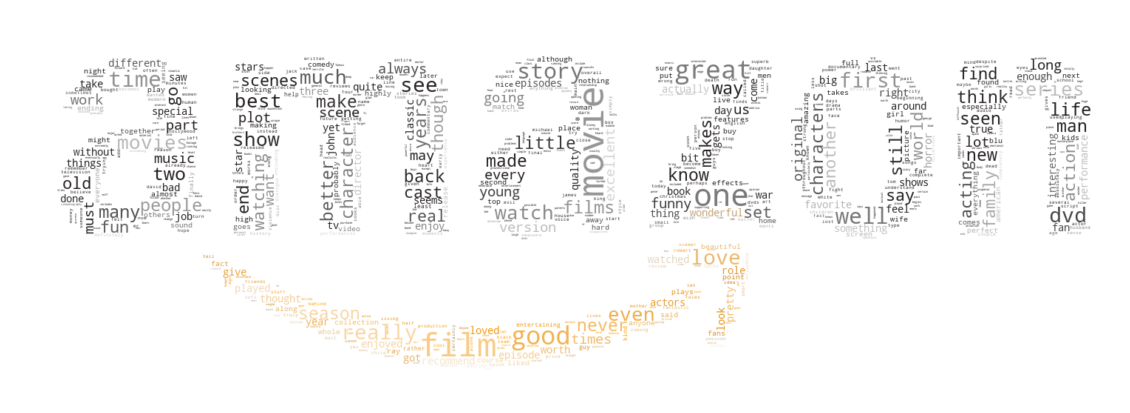

In [105]:
import os
from PIL import Image
from os import path, getcwd
from wordcloud import WordCloud, ImageColorGenerator
d = os.getcwd()
mask = np.array(Image.open(path.join(d, "amazon.jpg")))
wc = WordCloud(background_color="white", max_words=700, mask=mask,
               repeat = False, min_word_length=2, collocations=False, normalize_plurals = False,
               max_font_size=50, random_state=125)
wc.generate((text_pos2.replace("quot",""))) # Remove the string "quot" found in Amazon reviews that use quotation marks
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
_=plt.show()

### Negative Word Cloud

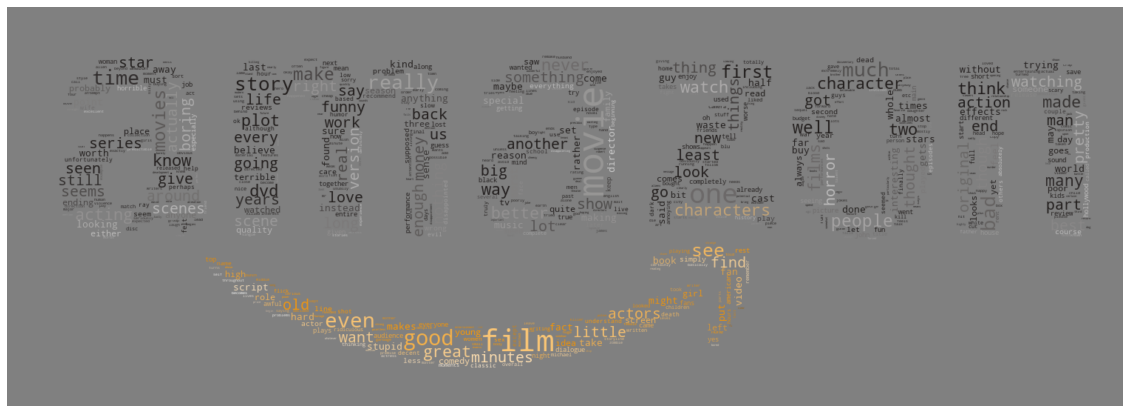

In [107]:
mask = np.array(Image.open(path.join(d, "amazon.jpg")))
wc = WordCloud(background_color="grey", max_words=700, mask=mask,
               repeat = False, min_word_length=2, collocations=False, normalize_plurals = False,
               max_font_size=50, random_state=125)
wc.generate((text_neg2.replace("quot",""))) # Remove the string "quot" found in Amazon reviews that use quotation marks
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
_=plt.show()